In [1]:
!python -V

Python 3.9.0


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

### Splitting the Data into `train.csv` and `test.csv`


In [3]:
# # Assuming you already have your full DataFrame loaded
df = pd.read_csv("./input_data/store_sales.csv")

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save them locally
train_df.to_csv("./input_data/train.csv", index=False)
test_df.to_csv("./input_data/test.csv", index=False)


In [4]:
# read the data
import pandas as pd

train_df = pd.read_csv("./input_data/train.csv")
test_df = pd.read_csv("./input_data/test.csv")

print(train_df.shape)
print(test_df.shape)


(5840, 5)
(1460, 5)


In [5]:
train_df.head()

,date,store,sales,promo,holiday
0,2022-01-01,2,167.91,0,0
1,2023-11-02,8,267.35,1,0
2,2022-11-02,7,241.79,0,0
3,2023-10-24,7,257.87,0,0
4,2022-11-22,1,242.64,0,0


In [6]:
# Show basic info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     5840 non-null   object 
 1   store    5840 non-null   int64  
 2   sales    5840 non-null   float64
 3   promo    5840 non-null   int64  
 4   holiday  5840 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 228.2+ KB


In [7]:
train_df.describe()

,store,sales,promo,holiday
count,5840.000000,5840.000000,5840.000000,5840.000000
mean,5.527740,228.559711,0.203596,0.103767
std,2.868157,26.571571,0.402706,0.304984
min,1.000000,160.710000,0.000000,0.000000
25%,3.000000,209.467500,0.000000,0.000000
50%,6.000000,226.905000,0.000000,0.000000
75%,8.000000,245.870000,0.000000,0.000000
max,10.000000,328.260000,1.000000,1.000000


In [8]:
train_df.store.describe()

count    5840.000000
mean        5.527740
std         2.868157
min         1.000000
25%         3.000000
50%         6.000000
75%         8.000000
max        10.000000
Name: store, dtype: float64

In [9]:
train_df.store.describe(percentiles = [0.95, 0.98, 0.99])

count    5840.000000
mean        5.527740
std         2.868157
min         1.000000
50%         6.000000
95%        10.000000
98%        10.000000
99%        10.000000
max        10.000000
Name: store, dtype: float64

In [10]:
# Convert date column to datetime
train_df["date"] = pd.to_datetime(train_df["date"])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     5840 non-null   datetime64[ns]
 1   store    5840 non-null   int64         
 2   sales    5840 non-null   float64       
 3   promo    5840 non-null   int64         
 4   holiday  5840 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 228.2 KB


In [11]:
# Check for duplicates and missing value
print("Missing values:\n", train_df.isnull().sum())
print("Duplicates:", train_df.duplicated().sum())

Missing values:
 date       0
store      0
sales      0
promo      0
holiday    0
dtype: int64
Duplicates: 0


<Axes: xlabel='store'>

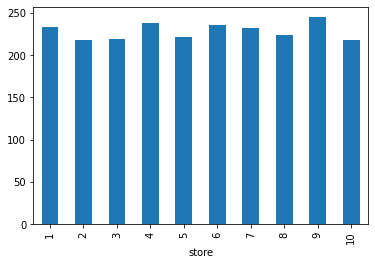

In [12]:
train_df.groupby("store")["sales"].mean().plot(kind="bar")

In [13]:
# Sort by store and date
train_df = train_df.sort_values(by=["store", "date"]).reset_index(drop=True)
train_df.tail()

,date,store,sales,promo,holiday
5835,2023-12-26,10,245.07,0,0
5836,2023-12-28,10,235.35,0,0
5837,2023-12-29,10,222.82,0,0
5838,2023-12-30,10,236.04,1,0
5839,2023-12-31,10,208.29,0,0


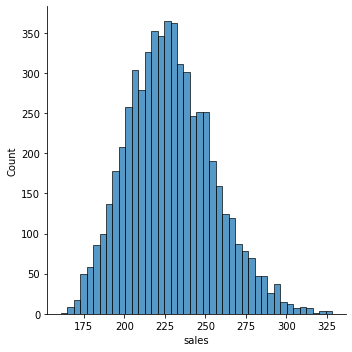

In [14]:
sns.displot(train_df.sales)

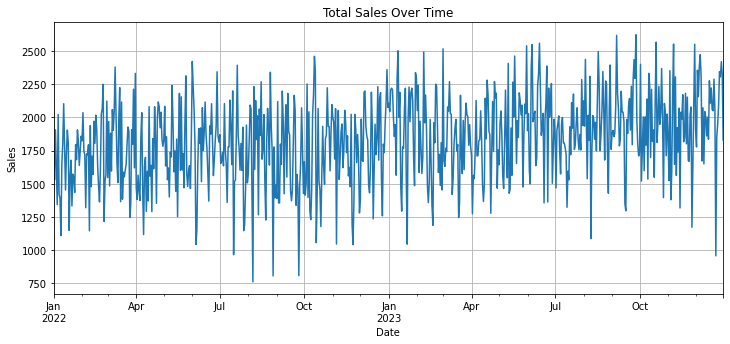

In [15]:
# 7. Quick Visual Check of Sales Trends
import matplotlib.pyplot as plt

# Total sales over time
train_df.groupby("date")["sales"].sum().plot(figsize=(12, 5))
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

In [16]:
# Feature Engineering — Date-based features
train_df["year"] = train_df["date"].dt.year
train_df["month"] = train_df["date"].dt.month
train_df["day"] = train_df["date"].dt.day
train_df["dayofweek"] = train_df["date"].dt.dayofweek
train_df["is_weekend"] = train_df["dayofweek"].isin([5, 6]).astype(int)

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        5840 non-null   datetime64[ns]
 1   store       5840 non-null   int64         
 2   sales       5840 non-null   float64       
 3   promo       5840 non-null   int64         
 4   holiday     5840 non-null   int64         
 5   year        5840 non-null   int64         
 6   month       5840 non-null   int64         
 7   day         5840 non-null   int64         
 8   dayofweek   5840 non-null   int64         
 9   is_weekend  5840 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 456.4 KB


In [18]:
# read the csv file
def read_dataframe(filename):
    df = pd.read_csv(filename)
    
    return df
    

In [19]:
# dataframe feature engineering and data labeling
def feature_engineering(df):
    df["date"] = pd.to_datetime(df["date"])
    
    # Feature Engineering — Date-based features
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["dayofweek"] = df["date"].dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

    # Define categorical features
    categorical = ["store", "promo", "holiday", "year", "month", "dayofweek", "is_weekend"]
    df_dicts = df[categorical].to_dict(orient="records")

    return df_dicts

In [20]:
# load and read datasets
train_df = read_dataframe("./input_data/train.csv")
test_df = read_dataframe("./input_data/test.csv")
print(train_df.shape)
print(test_df.shape)

(5840, 5)
(1460, 5)


In [21]:
# prepare features and dictionaries
train_dicts = feature_engineering(train_df)
test_dicts = feature_engineering(test_df)


In [22]:
# transform with DictVectorizer
dv = DictVectorizer()

X_train = dv.fit_transform(train_dicts)

X_test = dv.transform(test_dicts)

# Target from dataframe
y_train = train_df["sales"].values
y_test = test_df["sales"].values

In [23]:
print(X_train.shape)
print(X_test.shape)

(5840, 7)
(1460, 7)


### Train Linear Regression Model

In [24]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# RMSE
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
print("RMSE (Linear Regression):", round(rmse_lr, 2))


RMSE (Linear Regression): 13.46


#### Saved the trained model

In [27]:
# Save both the model and the DictVectorizer
with open("./model/lr_model.bin", "wb") as f_out:
    pickle.dump((dv, lr_model), f_out)

#### Load the saved model and make prediction

In [25]:
# Load the saved model and DictVectorizer
with open("./../saved_model/lr_model.bin", "rb") as f_in:
    dv_loaded, model_loaded = pickle.load(f_in)

# Example usage with new data (dict format)
new_data = {"store": 1, "promo": 0, "holiday": 0, "year": 2024, "month": 12, "dayofweek": 2, "is_weekend": 0}
X_new = dv_loaded.transform([new_data])
pred = model_loaded.predict(X_new)
print("Predicted Sales:", pred[0])

Predicted Sales: 259.45766222696693


#### Plotting Linear Regression Results

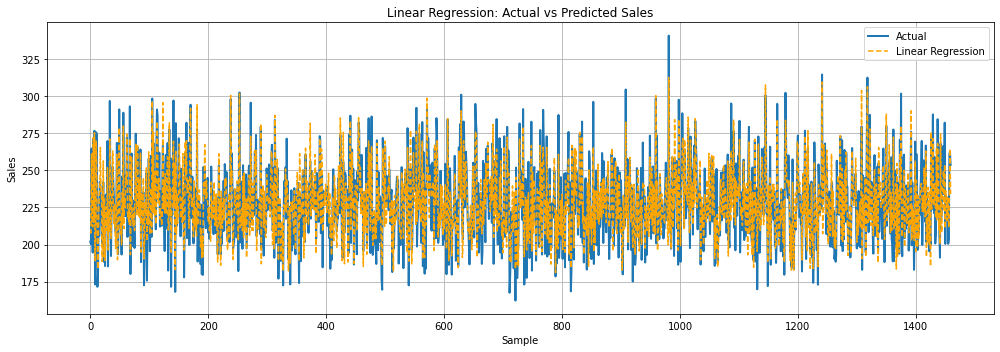

In [26]:
# Plot: Linear Regression vs Actual
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test, label="Actual", linewidth=2)
plt.plot(y_pred_lr, label="Linear Regression", linestyle="--", color="orange")
plt.title("Linear Regression: Actual vs Predicted Sales")
plt.xlabel("Sample")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Train Lasso Regrssion  model (l1 regularization)

In [27]:
# Train Lasso Regression model
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

# Predict
y_pred_lasso = lasso_model.predict(X_test)

# RMSE
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
print("RMSE (lasso Regression):", round(rmse_lasso, 2))


RMSE (lasso Regression): 14.5


### Train Ridge Regression (l2- Regulairzation)

In [28]:
# Train Ridge Regression model
ridge_model = Ridge(alpha=100)
ridge_model.fit(X_train, y_train)

# Predict
y_pred_ridge = ridge_model.predict(X_test)

# RMSE
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
print("RMSE (lasso Regression):", round(rmse_ridge, 2))


RMSE (lasso Regression): 13.65


### Train XGboost Regressor

In [29]:
# Train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# RMSE
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("RMSE (XGBoost):", round(rmse_xgb, 2))


RMSE (XGBoost): 5.35


#### Plotting XGBoost Resuts

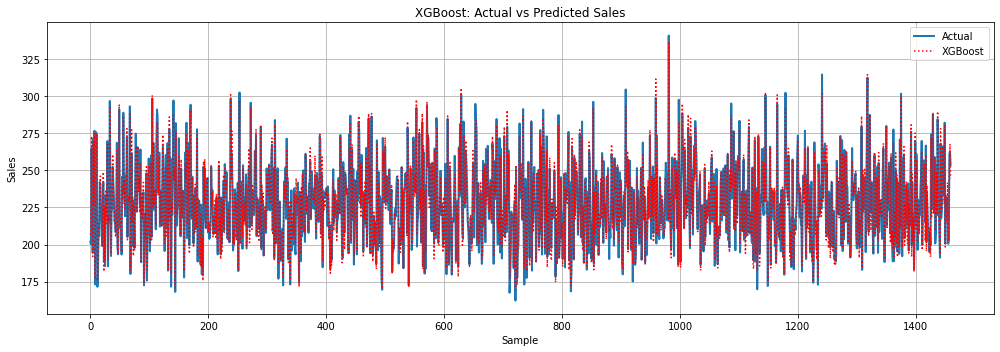

In [30]:
plt.figure(figsize=(14, 5))
plt.plot(y_test, label="Actual", linewidth=2)
plt.plot(y_pred_xgb, label="XGBoost", linestyle=":", color="red")
plt.title("XGBoost: Actual vs Predicted Sales")
plt.xlabel("Sample")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()